# Best model analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import optuna
import matplotlib.pyplot as plt
from collections import Counter
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from optuna.samplers import TPESampler 
from pandas.tseries.offsets import DateOffset
from collections import defaultdict
from statistics import mean
from joblib import Parallel, delayed
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import random
import itertools
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<br>

## Data preparation

In [2]:
data = pd.read_csv("final_data.csv", usecols = ['time', 'temperature', 'relative_humidity', 'apparent_temperature', 'region', 'consumption'])
data['time'] = pd.to_datetime(data['time']) 

In [3]:
with open('scenarios_final.pkl', 'rb') as scenarios_file:
    scenarios = pickle.load(scenarios_file)

<br>


In [4]:
data['peak_half_hour'] = 0

for region in data['region'].unique():
    region_data = data[data['region'] == region]
    max_consumption_index = region_data.groupby(region_data['time'].dt.date)['consumption'].idxmax()
    data.loc[max_consumption_index, 'peak_half_hour'] = 1

In [5]:
data['date'] = data['time'].dt.date

days_data = data.groupby(['date', 'region']).apply(lambda x: pd.Series({
    'date': x['date'].iloc[0],
    'region': x['region'].iloc[0],  
    'temperature': x['temperature'].values[:48],
    'apparent_temperature': x['apparent_temperature'].values[:48],
    'relative_humidity': x['relative_humidity'].values[:48],
    'consumption': x['consumption'].values[:48],
    'weekday': x['time'].dt.dayofweek.iloc[0],  
    'month': x['time'].dt.month.iloc[0],
    'peak_half_hour': x.index.get_loc(x[x['peak_half_hour'] == 1].index[0])
})).reset_index(drop=True)

In [6]:
days_data['date'] = pd.to_datetime(days_data['date'])
days_data = days_data.sort_values(by=['region', 'date'])

days_data['consumption(d-1)'] = days_data.groupby('region')['consumption'].shift(1)
days_data['peak_half_hour(d-1)'] = days_data.groupby('region')['peak_half_hour'].shift(1)
days_data['peak_half_hour(d-7)'] = days_data.groupby('region')['peak_half_hour'].shift(7)
days_data = days_data.dropna()

In [7]:
model_data = days_data[['date', 'region', 'consumption(d-1)', 'temperature', 'apparent_temperature', 'relative_humidity', 'weekday', 'month', 'peak_half_hour', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)']].copy()

new_column_names = [f"{col}_{i+1}" for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'] for i in range(48)]

data_expanded = pd.DataFrame()

for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)']:
    expanded_cols = pd.DataFrame(model_data[col].tolist(), columns=[f"{col}_{i+1}" for i in range(48)])
    data_expanded = pd.concat([data_expanded, expanded_cols], axis=1)

model_data.reset_index(drop=True, inplace=True)
data_expanded.reset_index(drop=True, inplace=True)

model_data_expanded = pd.concat([model_data, data_expanded], axis=1)
model_data_expanded = model_data_expanded.drop(['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'], axis=1)

<br>

- #### Classification approach



In [8]:
train_data_cat = model_data_expanded[model_data_expanded['date'].dt.year <= 2019]
test_data_cat = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 

X_train_cat = train_data_cat.drop(columns=['peak_half_hour', 'date'])
y_train_cat = train_data_cat['peak_half_hour']

X_test_cat = test_data_cat.drop(columns=['peak_half_hour', 'date'])
y_test_cat = test_data_cat['peak_half_hour']

In [9]:
for df in [X_train_cat, X_test_cat]:
    df['peak_half_hour(d-1)'] = df['peak_half_hour(d-1)'].astype('category')
    df['peak_half_hour(d-7)'] = df['peak_half_hour(d-7)'].astype('category')
    
    df['month'] = df['month'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

for target in [y_train_cat, y_test_cat]:
    target = target.astype('category')

<br>


In [10]:
numerical_columns_cat = X_train_cat.columns.difference(['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)'])
categorical_columns_cat = ['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns_cat),
        ('cat', categorical_transformer, categorical_columns_cat)
    ],
    remainder='passthrough'  
)

pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor)])

<br>

In [11]:
def within_range_cat(y_test, y_pred):
    accuracy = np.sum(np.abs(y_test.astype(int) - y_pred.astype(int)) <= 2) / len(y_test) * 100
    return accuracy

<br>

- #### Scenarios data


In [12]:
test_data = days_data[days_data['date'].dt.year == 2020].drop(columns='consumption')

new_test_data = pd.DataFrame()

for index, row in test_data.iterrows():
    date = row['date'].to_pydatetime().date()
    region = row['region']  
    
    scenarios_region = scenarios.get((region, date), [])
    
    for i, scenario in enumerate(scenarios_region): 
        lists = {}
        
        for col in ['temperature', 'apparent_temperature', 'relative_humidity']:
            lists[col] = scenario[col].tolist()
                
        temperature = lists['temperature']
        apparent_temperature = lists['apparent_temperature']
        relative_humidity = lists['relative_humidity']
        
        modified_row = row.copy()
        modified_row['temperature'] = temperature
        modified_row['apparent_temperature'] = apparent_temperature
        modified_row['relative_humidity'] = relative_humidity
        
        new_test_data = pd.concat([new_test_data, modified_row.to_frame().transpose()], ignore_index=True)

<br>



In [13]:
new_column_names = [f"{col}_{i+1}" for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'] for i in range(48)]

data_expanded = pd.DataFrame()

for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)']:
    expanded_cols = pd.DataFrame(new_test_data[col].tolist(), columns=[f"{col}_{i+1}" for i in range(48)])
    data_expanded = pd.concat([data_expanded, expanded_cols], axis=1)

new_test_data.reset_index(drop=True, inplace=True)
data_expanded.reset_index(drop=True, inplace=True)

new_test_data_expanded = pd.concat([new_test_data, data_expanded], axis=1)
new_test_data_expanded = new_test_data_expanded.drop(['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'], axis=1)

new_test_data_expanded = new_test_data_expanded.sort_values(by=['region', 'date'])

<br>

In [14]:
X_test_cat_scenarios = new_test_data_expanded.drop(columns=['peak_half_hour', 'date'])
y_test_cat_scenarios = new_test_data_expanded['peak_half_hour']

In [15]:
X_test_cat_scenarios['peak_half_hour(d-1)'] = X_test_cat_scenarios['peak_half_hour(d-1)'].astype('category')
X_test_cat_scenarios['peak_half_hour(d-7)'] = X_test_cat_scenarios['peak_half_hour(d-7)'].astype('category')

X_test_cat_scenarios['month'] = X_test_cat_scenarios['month'].astype('category')
X_test_cat_scenarios['weekday'] = X_test_cat_scenarios['weekday'].astype('category')

y_test_cat_scenarios = y_test_cat_scenarios.astype(int)

<br>  

## Best model: MLP Classifier (without SMOTE)

In [16]:
X_train_cat_nn = pipeline_cat.fit_transform(X_train_cat)
X_test_cat_nn = pipeline_cat.transform(X_test_cat)

In [17]:
best_params = {'n_layers': 2, 'units': 56, 'learning_rate': 0.0005289952047902762, 'batch_size': 44, 'dropout_rate': 0.08167052043499667, 'optimizer': 'RMSprop', 'activation': 'tanh', 'l2_regularization': 0.00022400329755390964}

In [18]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cat_best = Sequential()
nn_model_cat_best.add(Dense(best_units, input_dim=X_train_cat_nn.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cat_best.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cat_best.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cat_best.add(Dropout(best_dropout_rate))

nn_model_cat_best.add(Dense(48, activation='softmax'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cat_best.compile(optimizer=best_optimizer,
                          loss=SparseCategoricalCrossentropy(),
                          metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat_best.fit(X_train_cat_nn, y_train_cat, epochs=50, batch_size=best_batch_size, validation_data=(X_test_cat_nn, y_test_cat), verbose=0)

y_pred_prob = nn_model_cat_best.predict(X_test_cat_nn)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Accuracy: 58.47 %
Accuracy within a ±1 hour range: 75.36 %

MAE: 4.39


<br>

#### Using scenarios:

In [19]:
X_test_cat_scenarios_nn = pipeline_cat.transform(X_test_cat_scenarios)

In [20]:
y_pred_prob = nn_model_cat_best.predict(X_test_cat_scenarios_nn)
y_pred_red = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat_scenarios, y_pred_red) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat_scenarios, y_pred_red)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat_scenarios, y_pred_red)
print("\nMAE:", round(mae_y_pred, 2))

1236/1236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Accuracy: 55.03 %
Accuracy within a ±1 hour range: 70.48 %

MAE: 5.4


<br>

**Collectively:**

In [21]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common rounded values:", round(mae_y_pred_red,2))

Accuracy: 56.22 %
Accuracy within a ±1 hour range: 71.68 %

MAE of most common rounded values: 5.18


<br>

## Variables importance

In [22]:
num_features = numerical_columns_cat.tolist()

cat_transformer = pipeline_cat.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_columns_cat).tolist()

all_features = num_features + cat_features

passthrough_columns = X_train_cat.columns.difference(numerical_columns_cat.union(categorical_columns_cat)).tolist()

all_features += passthrough_columns

X_train_cat_nn_df = pd.DataFrame(X_train_cat_nn, columns=all_features)
X_test_cat_nn_df = pd.DataFrame(X_test_cat_nn, columns=all_features)

In [46]:
def permutation_importance(model, X_val, y_val, metric, n_repeats=10):
    baseline_score = metric(y_val, np.argmax(model.predict(X_val), axis=1))
    scores = np.zeros((X_val.shape[1], n_repeats))
    
    for i in range(X_val.shape[1]):
        X_permuted = X_val.copy()
        for n in range(n_repeats):
            np.random.shuffle(X_permuted[:, i])
            score = metric(y_val, np.argmax(model.predict(X_permuted), axis=1))
            scores[i, n] = score
    
    importance = baseline_score - scores.mean(axis=1)
    return importance

importance_scores = permutation_importance(nn_model_cat_best, X_test_cat_nn, y_test_cat, accuracy_score)

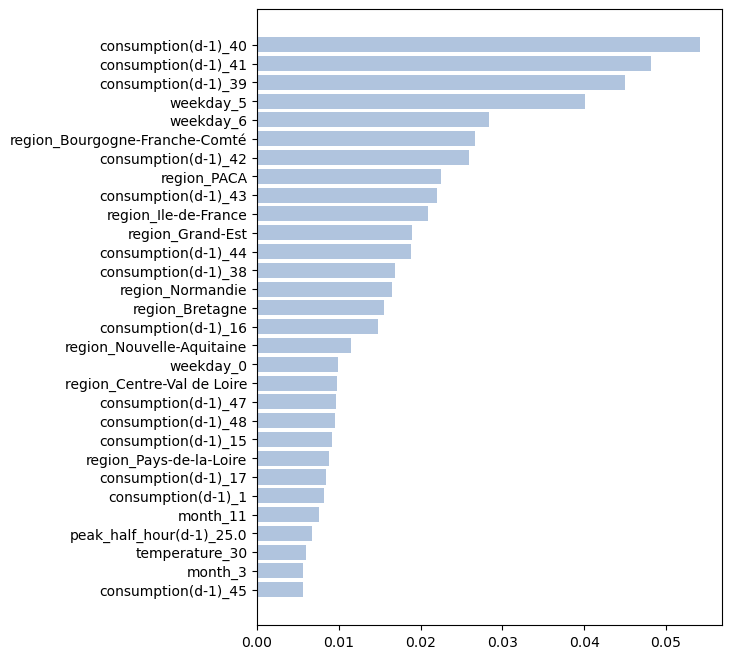

In [47]:
importance_dict = {all_features[idx]: score for idx, score in enumerate(importance_scores)}

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

top30_importance = sorted_importance[:30]

top30_feature_names = [item[0] for item in top30_importance]
top30_scores = [item[1] for item in top30_importance]

plt.figure(figsize=(6,8))
plt.barh(top30_feature_names, top30_scores, color='lightsteelblue')
plt.gca().invert_yaxis()
plt.savefig('top30.png', bbox_inches='tight')
plt.show()

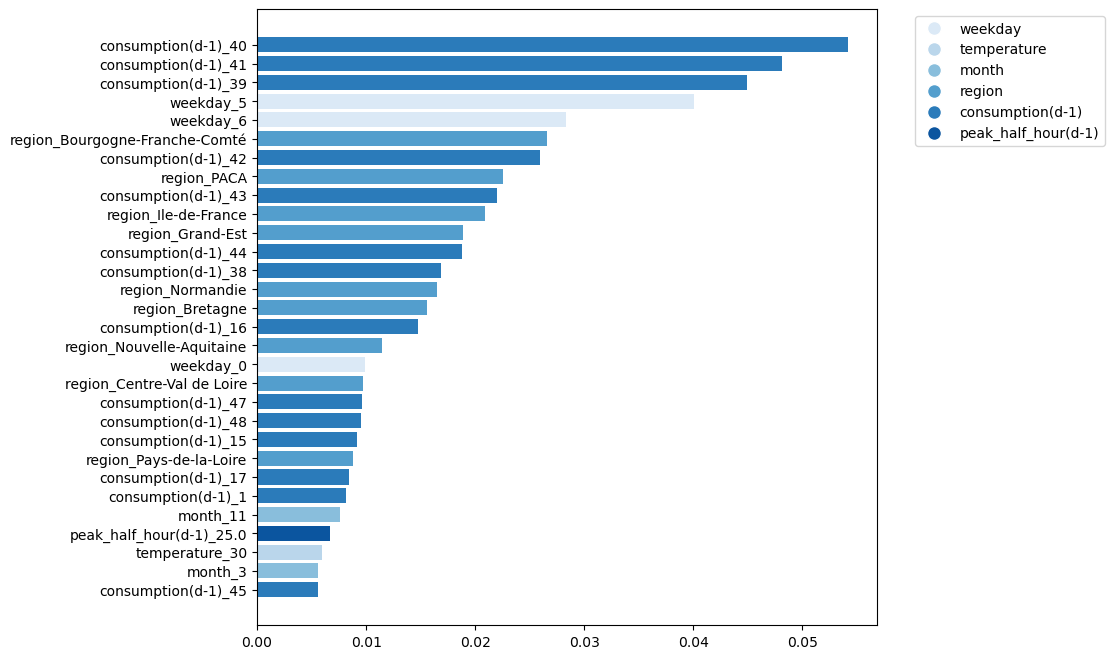

In [48]:
group_prefixes = ['_'.join(feature.split('_')[:-1]) for feature in top30_feature_names]

unique_prefixes = list(set(group_prefixes))
num_groups = len(unique_prefixes)
palette = sns.color_palette("Blues", num_groups)

color_mapping = {prefix: palette[i] for i, prefix in enumerate(unique_prefixes)}

colors = [color_mapping[group_prefixes[idx]] for idx in range(len(group_prefixes))]

plt.figure(figsize=(8,8))
plt.barh(range(len(top30_feature_names)), top30_scores, color=colors)
plt.yticks(range(len(top30_feature_names)), top30_feature_names)
plt.gca().invert_yaxis()

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=prefix) for i, prefix in enumerate(unique_prefixes)]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

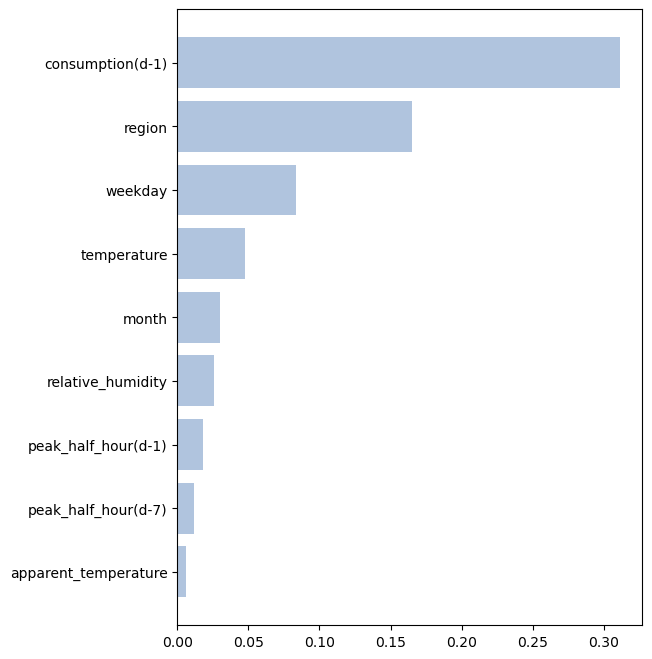

In [49]:
grouped_importance = defaultdict(float)
for feature, importance in zip(all_features, importance_scores):
    prefix = '_'.join(feature.split('_')[:-1])
    grouped_importance[prefix] += importance

grouped_importance_list = sorted(grouped_importance.items(), key=lambda x: x[1], reverse=True)

top_features, top_importances = zip(*grouped_importance_list)

plt.figure(figsize=(6,8))
plt.barh(range(len(top_features)), top_importances, color='lightsteelblue')
plt.yticks(range(len(top_features)), top_features)
plt.gca().invert_yaxis()
plt.savefig('top_group.png', bbox_inches='tight')
plt.show()

<br>

**Most important features** (top 50):
- 1: **consumption(d-1)** -> 1, 4, 15-18, 37-45, 47, 48
- 4:  **weekday** -> 0, 5-6 (weekend)
- 7: **region** -> Bourgogne-Franche-Comté, PACA, Ile-de-France, Grand-Est, Normandie, Bretagne, Nouvelle-Aquitaine, Centre-Val de Loire, Pays-de-la-Loire, Occitanie, Auvergne-Rhône-Alpes, Hauts-de-France
- 19: **month** -> 1, 3, 11, 12
- 27: **peak_half_hour(d-1)** -> 25, 26
- 31: **temperature** -> 14, 30, 38
- 32: **relative_humidity** -> 13, 33, 35, 39, 48
- 39: **peak_half_hour(d-7)** -> 25, 26
- 47: **apparent_temperature** -> 3, 48

<br>

<br>

### Adding 'is_weekend'

In [54]:
days_data['is_weekend'] = np.where(days_data['weekday'].isin([5, 6]), 1, 0)

In [55]:
model_data = days_data[['date', 'region', 'consumption(d-1)', 'temperature', 'apparent_temperature', 'relative_humidity', 'weekday', 'month', 'peak_half_hour', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)', 'is_weekend']].copy()

new_column_names = [f"{col}_{i+1}" for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'] for i in range(48)]

data_expanded = pd.DataFrame()

for col in ['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)']:
    expanded_cols = pd.DataFrame(model_data[col].tolist(), columns=[f"{col}_{i+1}" for i in range(48)])
    data_expanded = pd.concat([data_expanded, expanded_cols], axis=1)

model_data.reset_index(drop=True, inplace=True)
data_expanded.reset_index(drop=True, inplace=True)

model_data_expanded = pd.concat([model_data, data_expanded], axis=1)
model_data_expanded = model_data_expanded.drop(['temperature', 'apparent_temperature', 'relative_humidity', 'consumption(d-1)'], axis=1)

In [56]:
train_data_cat2 = model_data_expanded[model_data_expanded['date'].dt.year <= 2019]
test_data_cat2 = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 

X_train_cat2 = train_data_cat2.drop(columns=['peak_half_hour', 'date'])
y_train_cat2 = train_data_cat2['peak_half_hour']

X_test_cat2 = test_data_cat2.drop(columns=['peak_half_hour', 'date'])
y_test_cat2 = test_data_cat2['peak_half_hour']

In [57]:
for df in [X_train_cat2, X_test_cat2]:
    df['peak_half_hour(d-1)'] = df['peak_half_hour(d-1)'].astype('category')
    df['peak_half_hour(d-7)'] = df['peak_half_hour(d-7)'].astype('category')
    
    df['month'] = df['month'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

for target in [y_train_cat2, y_test_cat2]:
    target = target.astype('category')

In [58]:
numerical_columns_cat = X_train_cat2.columns.difference(['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)', 'is_weekend'])
categorical_columns_cat = ['region', 'month', 'weekday', 'peak_half_hour(d-1)', 'peak_half_hour(d-7)', 'is_weekend']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns_cat),
        ('cat', categorical_transformer, categorical_columns_cat)
    ],
    remainder='passthrough'  
)

pipeline_cat2 = Pipeline(steps=[('preprocessor', preprocessor)])

<br>

In [60]:
X_train_cat_nn_new = pipeline_cat2.fit_transform(X_train_cat2)
X_test_cat_nn_new = pipeline_cat2.transform(X_test_cat2)

In [61]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cat_best_new = Sequential()
nn_model_cat_best_new.add(Dense(best_units, input_dim=X_train_cat_nn_new.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cat_best_new.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cat_best_new.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cat_best_new.add(Dropout(best_dropout_rate))

nn_model_cat_best_new.add(Dense(48, activation='softmax'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cat_best_new.compile(optimizer=best_optimizer,
                          loss=SparseCategoricalCrossentropy(),
                          metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat_best_new.fit(X_train_cat_nn_new, y_train_cat, epochs=50, batch_size=best_batch_size, validation_data=(X_test_cat_nn_new, y_test_cat), verbose=0)

y_pred_prob = nn_model_cat_best_new.predict(X_test_cat_nn_new)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy: 58.45 %
Accuracy within a ±1 hour range: 75.02 %

MAE: 4.44


<br>

| Approach                               | Accuracy | ±1 hour range accuracy | MAE  |
|----------------------------------------|----------|------------------------|------|
| Original variables                     | **58.47** | **75.36**                | **4.39** |
| Original variables + 'is_weekend'      | 58.45   | 75.02                 | 4.44 |

<br>

**Best approach:** Original variables.


<br>

### Threshold optimization to eliminate redundant variables:

In [66]:
threshold_importance_values = [0, 0.0001, 0.001]
threshold_correlation_values = [0, 0.01]
threshold_variance_values = [0, 0.001, 0.01]

combinations = list(itertools.product(threshold_importance_values, threshold_correlation_values, threshold_variance_values))

best_accuracy = 0
best_combination = None
best_model = None

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

for threshold_importance, threshold_correlation, threshold_variance in combinations:
    low_importance_vars = [all_features[idx] for idx, importance in enumerate(importance_scores) if abs(importance) < threshold_importance]
    low_corr_vars = [column for column in all_features if abs(X_train_cat_nn_df[column].corr(y_test_cat)) < threshold_correlation]
    low_variance_vars = [column for column in all_features if X_train_cat_nn_df[column].var() < threshold_variance]

    variables_a_eliminar = set(low_importance_vars + low_corr_vars + low_variance_vars)

    X_train_cat_filtrado = X_train_cat_nn_df.drop(variables_a_eliminar, axis=1)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_cat_filtrado, y_train_cat, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Dense(best_params['units'], input_dim=X_train_split.shape[1], activation=best_params['activation'], kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_regularization'])))
    model.add(Dropout(best_params['dropout_rate']))

    for _ in range(best_params['n_layers']):
        model.add(Dense(best_params['units'], activation=best_params['activation'], kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_regularization'])))
        model.add(Dropout(best_params['dropout_rate']))

    model.add(Dense(48, activation='softmax'))

    if best_params['optimizer'] == 'Adam':
        best_optimizer = Adam(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'SGD':
        best_optimizer = SGD(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'RMSprop':
        best_optimizer = RMSprop(learning_rate=best_params['learning_rate'])

    model.compile(optimizer=best_optimizer,
                              loss=SparseCategoricalCrossentropy(),
                              metrics=[SparseCategoricalAccuracy()])

    history = model.fit(X_train_split, y_train_split, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val_split, y_val_split), verbose=0)

    y_pred_prob = model.predict(X_val_split)
    y_pred = np.argmax(y_pred_prob, axis=1)

    accuracy = accuracy_score(y_val_split, y_pred) * 100

    print(f"Combination (importance, correlation, variance): ({threshold_importance}, {threshold_correlation}, {threshold_variance})")
    print(f"Accuracy: {round(accuracy, 2)} %\n")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_combination = (threshold_importance, threshold_correlation, threshold_variance)
        best_model = model

print("\nBest thresholds:", best_combination)
print("Best accuracy:", round(best_accuracy, 2), '%')

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Combination (importance, correlation, variance): (0, 0, 0)
Accuracy: 60.4 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Combination (importance, correlation, variance): (0, 0, 0.001)
Accuracy: 60.05 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Combination (importance, correlation, variance): (0, 0, 0.01)
Accuracy: 60.84 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Combination (importance, correlation, variance): (0, 0.01, 0)
Accuracy: 59.76 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Combination (importance, correlation, variance): (0, 0.01, 0.001)
Accuracy: 60.36 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Combination (importance, correlation, variance): (0, 0.01, 0.01)
Accuracy: 60.25 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Combination (importance, correlation, variance): (0.0001, 0, 0)
Accuracy: 59.91 %

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Combination (importance, correlation, variance): (0.0001, 0, 0.001)
Accuracy: 60.76 %

192/192 ━━━━

<br>

In [67]:
threshold_importance = 0
threshold_correlation = 0 
threshold_variance = 0.01

low_importance_vars = [all_features[idx] for idx, importance in enumerate(importance_scores) if abs(importance) < threshold_importance]
low_corr_vars = [column for column in all_features if abs(X_train_cat_nn_df[column].corr(y_test_cat)) < threshold_correlation]
low_variance_vars = [column for column in all_features if X_train_cat_nn_df[column].var() < threshold_variance]

variables_a_eliminar = set(low_importance_vars + low_corr_vars + low_variance_vars)

X_train_cat_filtrado = X_train_cat_nn_df.drop(variables_a_eliminar, axis=1)
X_test_cat_filtrado = X_test_cat_nn_df.drop(variables_a_eliminar, axis=1)

In [68]:
X_train_cat_filtrado.head(5)

,apparent_temperature_1,apparent_temperature_10,apparent_temperature_11,apparent_temperature_12,apparent_temperature_13,apparent_temperature_14,apparent_temperature_15,apparent_temperature_16,apparent_temperature_17,apparent_temperature_18,...,peak_half_hour(d-7)_24.0,peak_half_hour(d-7)_25.0,peak_half_hour(d-7)_26.0,peak_half_hour(d-7)_27.0,peak_half_hour(d-7)_29.0,peak_half_hour(d-7)_38.0,peak_half_hour(d-7)_39.0,peak_half_hour(d-7)_40.0,peak_half_hour(d-7)_46.0,peak_half_hour(d-7)_47.0
0,-1.490445,-1.429850,-1.444164,-1.441356,-1.436748,-1.445317,-1.448423,-1.470785,-1.488204,-1.417527,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.564784,-1.594369,-1.581816,-1.574314,-1.563636,-1.590876,-1.610929,-1.612094,-1.608816,-1.531223,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.547527,-1.577779,-1.558415,-1.531338,-1.502154,-1.474428,-1.444757,-1.467192,-1.484691,-1.502219,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.056359,-0.900348,-0.966509,-0.984735,-1.001143,-0.993451,-0.984120,-1.018115,-1.046743,-1.092678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.189107,-1.248741,-1.259709,-1.285568,-1.305936,-1.327604,-1.342122,-1.383364,-1.417945,-1.426808,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [69]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

best_units = best_params['units']
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']
best_optimizer_name = best_params['optimizer']
best_activation = best_params['activation']
best_l2_regularization = best_params['l2_regularization']

nn_model_cat_best_new = Sequential()
nn_model_cat_best_new.add(Dense(best_units, input_dim=X_train_cat_filtrado.shape[1], activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
nn_model_cat_best_new.add(Dropout(best_dropout_rate))

for _ in range(best_n_layers):
    nn_model_cat_best_new.add(Dense(best_units, activation=best_activation, kernel_regularizer=tf.keras.regularizers.l2(best_l2_regularization)))
    nn_model_cat_best_new.add(Dropout(best_dropout_rate))

nn_model_cat_best_new.add(Dense(48, activation='softmax'))

if best_optimizer_name == 'Adam':
    best_optimizer = Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = RMSprop(learning_rate=best_learning_rate)

nn_model_cat_best_new.compile(optimizer=best_optimizer,
                          loss=SparseCategoricalCrossentropy(),
                          metrics=[SparseCategoricalAccuracy()])

history = nn_model_cat_best_new.fit(X_train_cat_filtrado, y_train_cat, epochs=50, batch_size=best_batch_size, validation_data=(X_test_cat_filtrado, y_test_cat), verbose=0)

y_pred_prob = nn_model_cat_best_new.predict(X_test_cat_filtrado)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_cat, y_pred) * 100
print("\nAccuracy:", round(accuracy, 2), '%')

within_range_accuracy = within_range_cat(y_test_cat, y_pred)
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred = mean_absolute_error(y_test_cat, y_pred)
print("\nMAE:", round(mae_y_pred, 2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Accuracy: 58.52 %
Accuracy within a ±1 hour range: 74.93 %

MAE: 4.5


<br>

| Approach                               | Accuracy | ±1 hour range accuracy | MAE  |
|----------------------------------------|----------|------------------------|------|
| Original variables                     | 58.47 | **75.36**                | **4.39** |
| Filtered variables     | **58.52**  | 74.93                 | 4.50 |



<br>

## Example for Auvergne-Rhône-Alpes

In [74]:
X_test_cat_filtered = X_test_cat_scenarios[X_test_cat_scenarios['region'] == 'Auvergne-Rhône-Alpes'].copy()

test_data_cat = model_data_expanded[model_data_expanded['date'].dt.year == 2020] 
test_data_cat_filtered = test_data_cat[test_data_cat['region'] == 'Auvergne-Rhône-Alpes'].copy()
y_test_cat_filtered = test_data_cat_filtered['peak_half_hour']

In [75]:
X_test_cat_scenarios_nn_filtered = pipeline_cat.transform(X_test_cat_filtered)

y_pred_prob = nn_model_cat_best.predict(X_test_cat_scenarios_nn_filtered)
y_pred_red = np.argmax(y_pred_prob, axis=1)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [78]:
y_pred_groups = [y_pred_red[i:i+9] for i in range(0, len(y_pred_red), 9)]
most_common_values = [Counter(group).most_common(1)[0][0] for group in y_pred_groups]
real_values = y_test_cat_filtered

correct_predictions = sum(1 for pred, true in zip(most_common_values, real_values) if pred == true)
accuracy = (correct_predictions / len(real_values)) * 100
print("Accuracy:", round(accuracy,2), '%')

within_range = sum(1 for pred, true in zip(most_common_values, real_values) if abs(pred - true) <= 2)
within_range_accuracy = (within_range / len(real_values)) * 100
print(f'Accuracy within a ±1 hour range: {round(within_range_accuracy, 2)} %')

mae_y_pred_red = mean_absolute_error(real_values, most_common_values)
print("\nMAE of most common values:", round(mae_y_pred_red,2))

Accuracy: 48.09 %
Accuracy within a ±1 hour range: 69.67 %

MAE of most common values: 4.77


<br>

First three months predictions:

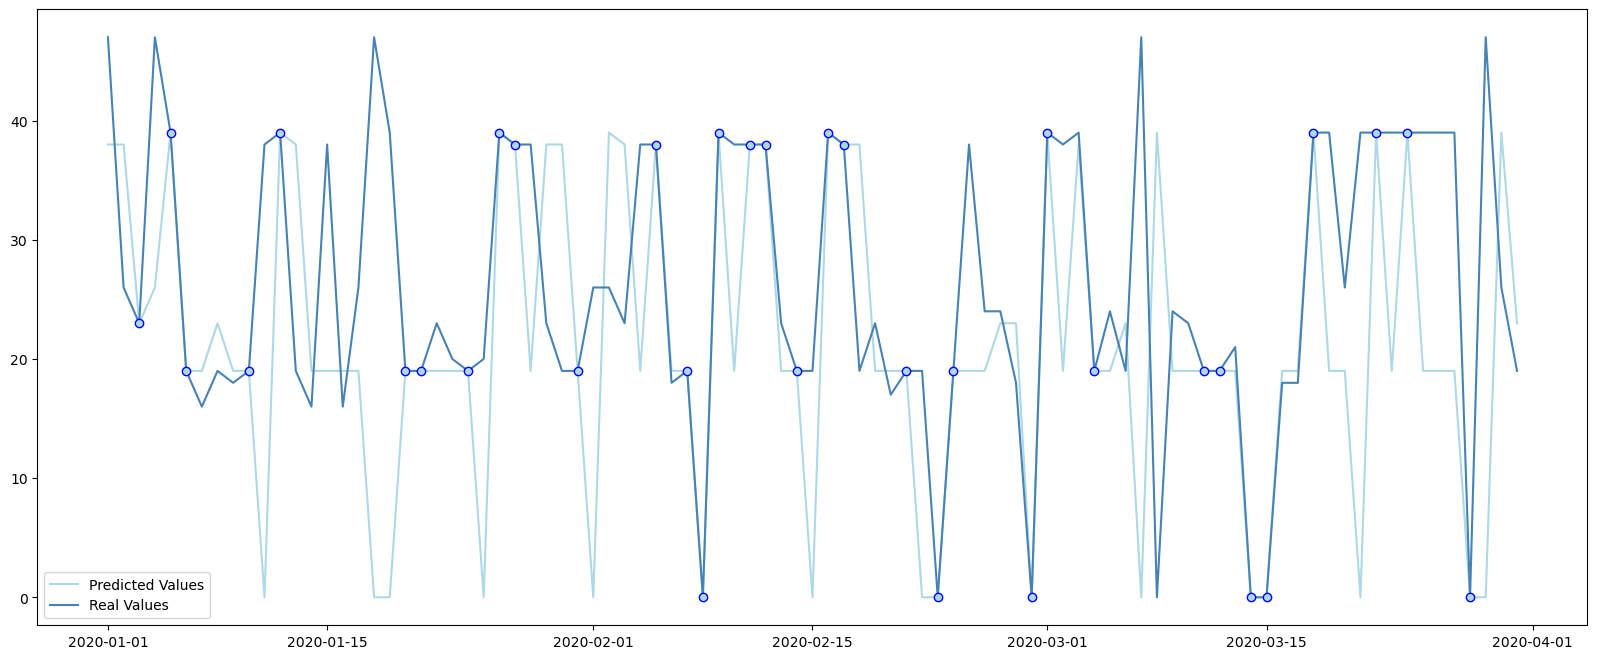

In [79]:
dates = pd.date_range(start='2020-01-01', end='2020-03-31')

df = pd.DataFrame({'Predicted Values': most_common_values[0:91], 'Real Values': real_values[0:91]})
df['dates'] = dates
df.set_index('dates', inplace=True)

plt.figure(figsize=(20, 8))

plt.plot(df.index, df['Predicted Values'], label='Predicted Values', color='lightblue')
plt.plot(df.index, df['Real Values'], label='Real Values', color='steelblue')

coincident_points = df[df['Predicted Values'] == df['Real Values']]
plt.plot(coincident_points.index, coincident_points['Predicted Values'], 'bo', markersize=6, markerfacecolor='lightblue')
plt.legend(loc='lower left')
plt.show()